# Installs & Imports

In [19]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [5]:
def load_mnist_data(data_dir='./data'):
    """
    Loads the MNIST dataset using torchvision.

    Returns:
      train_dataset: training dataset (torchvision format)
      test_dataset: test dataset (torchvision format)
    """
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
    return train_dataset, test_dataset

In [6]:
# Load MNIST data
train_dataset, test_dataset = load_mnist_data()
print("\nMNIST data loaded.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.93MB/s]


MNIST data loaded.


# Data Preparation

In [7]:
def prepare_data(dataset):
    """
    Converts a torchvision dataset into numpy arrays.

    Returns:
      X: numpy array of flattened images (n_samples, 784)
      y: numpy array of labels (n_samples,)
    """
    X, y = [], []
    for img, label in dataset:
        X.append(img.view(-1).numpy())
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [8]:
# Prepare training and test arrays
X_train_all, y_train_all = prepare_data(train_dataset)
X_test, y_test = prepare_data(test_dataset)
print(f"Training data shape: {X_train_all.shape}, Test data shape: {X_test.shape}")

Training data shape: (60000, 784), Test data shape: (10000, 784)


# Pipeline Definition

In [9]:
def apply_pca(X_train, X_val, n_components=50):
    """
    Applies PCA to the data.

    Returns:
      X_train_pca: PCA-transformed training data.
      X_val_pca: PCA-transformed validation data.
      pca: the fitted PCA object.
    """
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    return X_train_pca, X_val_pca, pca

In [10]:
class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64), num_classes=10):
        """
        A simple feed-forward neural network with two hidden layers.
        """
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
def train_dnn_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=15,
    batch_size=128,
    lr=1e-3
):
    """
    Trains a PyTorch DNN model on the provided data.

    Returns:
      val_acc: Validation accuracy after training.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor)
        _, preds = torch.max(outputs, 1)
        correct = (preds == y_val_tensor).sum().item()
        total = y_val_tensor.size(0)
        val_acc = correct / total
    return val_acc

In [13]:
class WOAFeatureSelector:
    """
    Whale Optimization Algorithm (WOA) for feature selection on PCA-transformed data.

    This version uses internal cross-validation (via StratifiedKFold) to evaluate each candidate,
    thereby reducing overinflated candidate fitness estimates. It also allows tuning of the internal
    DNNClassifier hyperparameters used for candidate evaluation.

    Tunable internal DNN parameters:
      - candidate_dnn_hidden_dims: tuple (e.g. (128, 64))
      - candidate_dnn_epochs: int (number of epochs for candidate training)
      - candidate_dnn_batch_size: int (batch size for candidate training)
      - candidate_dnn_lr: float (learning rate for candidate training)

    internal_cv: number of folds for internal CV (default=3)
    """
    def __init__(
        self,
        n_features,
        population_size=10,
        max_iter=10,
        epochs=15,
        batch_size=128,
        lr=1e-3,
        spiral_constant=1.0,
        threshold=0.5,
        scale_a=2.0,
        scale_C=2.0,
        p_threshold=0.5,
        candidate_dnn_hidden_dims=(128, 64),
        candidate_dnn_epochs=15,
        candidate_dnn_batch_size=128,
        candidate_dnn_lr=1e-3,
        internal_cv=3,
        random_seed=None,
        verbose=True
    ):
        self.n_features = n_features
        self.population_size = population_size
        self.max_iter = max_iter
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.spiral_constant = spiral_constant
        self.threshold = threshold
        self.scale_a = scale_a
        self.scale_C = scale_C
        self.p_threshold = p_threshold
        self.candidate_dnn_hidden_dims = candidate_dnn_hidden_dims
        self.candidate_dnn_epochs = candidate_dnn_epochs
        self.candidate_dnn_batch_size = candidate_dnn_batch_size
        self.candidate_dnn_lr = candidate_dnn_lr
        self.internal_cv = internal_cv
        self.verbose = verbose
        if random_seed is not None:
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)

    def _get_binary_mask(self, position):
        return (position >= self.threshold).astype(int)

    def initialize_population(self):
        return np.random.rand(self.population_size, self.n_features)

    def _train_candidate(self, candidate_mask, X, y):
        """
        Evaluates a candidate feature subset by performing internal cross-validation.
        For each fold, trains a DNN using the candidate's selected features (with tunable internal hyperparameters)
        and returns the average accuracy.
        """
        selected_indices = np.where(candidate_mask == 1)[0]
        if len(selected_indices) == 0:
            return 0.0
        X_sub = X[:, selected_indices]
        skf = StratifiedKFold(n_splits=self.internal_cv, shuffle=True, random_state=42)
        accuracies = []
        for train_idx, val_idx in skf.split(X_sub, y):
            X_train_cv, X_val_cv = X_sub[train_idx], X_sub[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]
            input_dim = X_train_cv.shape[1]
            model = DNNClassifier(
                input_dim=input_dim,
                hidden_dims=self.candidate_dnn_hidden_dims
            )
            acc = train_dnn_model(
                model,
                X_train_cv,
                y_train_cv,
                X_val_cv,
                y_val_cv,
                epochs=self.candidate_dnn_epochs,
                batch_size=self.candidate_dnn_batch_size,
                lr=self.candidate_dnn_lr
            )
            accuracies.append(acc)
        return np.mean(accuracies)

    def optimize(self, X, y):
        """
        Runs WOA to select an optimal feature subset using the provided training fold (X, y),
        with internal cross-validation for candidate evaluation.

        Returns:
          best_mask: binary mask of selected features.
          best_fitness: best internal CV accuracy achieved.
          convergence_curve: list of best fitness values per iteration.
        """
        population = self.initialize_population()
        fitness = np.zeros(self.population_size)
        best_fitness = -np.inf
        best_position = None

        # Evaluate initial population
        for i in range(self.population_size):
            candidate_mask = self._get_binary_mask(population[i])
            fit = self._train_candidate(candidate_mask, X, y)
            fitness[i] = fit
            if fit > best_fitness:
                best_fitness = fit
                best_position = population[i].copy()
        if self.verbose:
            print(f"\n[WOA] Initial best fitness: {best_fitness:.4f}")
        convergence_curve = [best_fitness]

        # Main WOA loop
        for iter in range(1, self.max_iter + 1):
            a = self.scale_a * (1 - iter / self.max_iter)
            for i in range(self.population_size):
                r1, r2 = np.random.rand(), np.random.rand()
                A = self.scale_a * a * r1 - a
                C = self.scale_C * r2
                p = np.random.rand()
                if p < self.p_threshold:
                    if abs(A) < 1:
                        D = abs(C * best_position - population[i])
                        new_position = best_position - A * D
                    else:
                        rand_idx = np.random.randint(0, self.population_size)
                        random_whale = population[rand_idx]
                        D = abs(C * random_whale - population[i])
                        new_position = random_whale - A * D
                else:
                    D_prime = abs(best_position - population[i])
                    l = np.random.uniform(-1, 1)
                    new_position = D_prime * math.exp(self.spiral_constant * l) * math.cos(2 * math.pi * l) + best_position
                population[i] = np.clip(new_position, 0, 1)
            for i in range(self.population_size):
                candidate_mask = self._get_binary_mask(population[i])
                fit = self._train_candidate(candidate_mask, X, y)
                fitness[i] = fit
                if fit > best_fitness:
                    best_fitness = fit
                    best_position = population[i].copy()
            convergence_curve.append(best_fitness)
            if self.verbose:
                print(f"[WOA] Iteration {iter}: Best fitness = {best_fitness:.4f}")
        best_mask = self._get_binary_mask(best_position)
        return best_mask, best_fitness, convergence_curve

In [14]:
class DNNPipelineEstimator(BaseEstimator, ClassifierMixin):
    """
    A scikit-learn compatible estimator that implements the unified pipeline:
      1. PCA transformation with configurable n_components.
      2. WOA feature selection (with internal CV for candidate evaluation, including tunable internal DNN hyperparameters).
      3. Training a DNN classifier on the selected features.

    The fit method uses the entire training fold provided by external CV.
    """
    def __init__(
        self,
        pca_n_components=50,
        woa_population_size=10,
        woa_max_iter=10,
        woa_epochs=15,
        woa_batch_size=128,
        woa_lr=1e-3,
        woa_spiral_constant=1.0,
        woa_threshold=0.5,
        woa_scale_a=2.0,
        woa_scale_C=2.0,
        woa_p_threshold=0.5,
        candidate_dnn_hidden_dims=(128, 64),
        candidate_dnn_epochs=15,
        candidate_dnn_batch_size=128,
        candidate_dnn_lr=1e-3,
        dnn_hidden_dims=(128, 64),
        dnn_epochs=15,
        dnn_batch_size=128,
        dnn_lr=1e-3,
        random_seed=42,
        verbose=True
    ):
        self.pca_n_components = pca_n_components
        self.woa_population_size = woa_population_size
        self.woa_max_iter = woa_max_iter
        self.woa_epochs = woa_epochs
        self.woa_batch_size = woa_batch_size
        self.woa_lr = woa_lr
        self.woa_spiral_constant = woa_spiral_constant
        self.woa_threshold = woa_threshold
        self.woa_scale_a = woa_scale_a
        self.woa_scale_C = woa_scale_C
        self.woa_p_threshold = woa_p_threshold
        self.candidate_dnn_hidden_dims = candidate_dnn_hidden_dims
        self.candidate_dnn_epochs = candidate_dnn_epochs
        self.candidate_dnn_batch_size = candidate_dnn_batch_size
        self.candidate_dnn_lr = candidate_dnn_lr
        self.dnn_hidden_dims = dnn_hidden_dims
        self.dnn_epochs = dnn_epochs
        self.dnn_batch_size = dnn_batch_size
        self.dnn_lr = dnn_lr
        self.random_seed = random_seed
        self.verbose = verbose

    def fit(self, X, y):
        self.pca_ = PCA(n_components=self.pca_n_components)
        X_pca = self.pca_.fit_transform(X)
        self.woa_ = WOAFeatureSelector(
            n_features=self.pca_n_components,
            population_size=self.woa_population_size,
            max_iter=self.woa_max_iter,
            epochs=self.woa_epochs,
            batch_size=self.woa_batch_size,
            lr=self.woa_lr,
            spiral_constant=self.woa_spiral_constant,
            threshold=self.woa_threshold,
            scale_a=self.woa_scale_a,
            scale_C=self.woa_scale_C,
            p_threshold=self.woa_p_threshold,
            internal_cv=3,
            candidate_dnn_hidden_dims=self.candidate_dnn_hidden_dims,
            candidate_dnn_epochs=self.candidate_dnn_epochs,
            candidate_dnn_batch_size=self.candidate_dnn_batch_size,
            candidate_dnn_lr=self.candidate_dnn_lr,
            random_seed=self.random_seed,
            verbose=self.verbose
        )
        best_mask, best_fitness, _ = self.woa_.optimize(X_pca, y)
        self.best_mask_ = best_mask
        self.selected_indices_ = np.where(best_mask == 1)[0]
        if len(self.selected_indices_) == 0:
            raise ValueError("WOA selected no features.")
        X_sel = X_pca[:, self.selected_indices_]
        input_dim = X_sel.shape[1]
        self.clf_ = DNNClassifier(
            input_dim=input_dim,
            hidden_dims=self.dnn_hidden_dims
        )
        self.clf_val_acc_ = train_dnn_model(
            self.clf_,
            X_sel,
            y,
            X_sel,
            y,
            epochs=self.dnn_epochs,
            batch_size=self.dnn_batch_size,
            lr=self.dnn_lr
        )
        if self.verbose:
            print(f"\n[DIAGNOSTIC] Accuracy on training fold (overly optimistic): {self.clf_val_acc_:.4f}")
        return self

    def predict(self, X):
        X_pca = self.pca_.transform(X)
        X_sel = X_pca[:, self.selected_indices_]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.clf_.to(device)
        self.clf_.eval()
        X_tensor = torch.tensor(X_sel, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = self.clf_(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.cpu().numpy()

    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)

# Hyperparameter Tuning

In [16]:
X_tune, y_tune = X_train_all, y_train_all

In [17]:
# ---- DNN Pipeline with RandomizedSearchCV ----
print("Starting RandomizedSearchCV for DNN pipeline...")
dnn_pipeline = DNNPipelineEstimator(verbose=True)
dnn_param_dist = {
    "pca_n_components": [40, 50, 60],
    "woa_population_size": [10, 20],
    "woa_max_iter": [3, 5],
    "woa_epochs": [10, 15],
    "woa_p_threshold": [0.4, 0.5, 0.6],
    "woa_scale_a": [1.5, 2.0, 2.5],
    "woa_scale_C": [1.5, 2.0, 2.5],
    # Hyperparameters for internal candidate DNN (in WOA):
    "candidate_dnn_hidden_dims": [(128, 64), (256, 128)],
    "candidate_dnn_epochs": [10, 15],
    "candidate_dnn_batch_size": [128],
    "candidate_dnn_lr": [1e-3, 5e-4],
    # Outer DNN classifier hyperparameters:
    "dnn_hidden_dims": [(128, 64), (256, 128)],
    "dnn_epochs": [15, 20],
    "dnn_lr": [1e-3, 5e-4]
}

dnn_search = RandomizedSearchCV(
    estimator=dnn_pipeline,
    param_distributions=dnn_param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    random_state=42,
    verbose=2,
    n_jobs=1
)

dnn_search.fit(X_tune, y_tune)
print("\nBest DNN pipeline parameters (RandomizedSearchCV):")
print(dnn_search.best_params_)
print(f"\nBest DNN CV accuracy (RandomizedSearchCV): {dnn_search.best_score_:.4f}")
dnn_cv_best = dnn_search.best_estimator_

Starting RandomizedSearchCV for DNN pipeline...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[WOA] Initial best fitness: 0.9513
[WOA] Iteration 1: Best fitness = 0.9684
[WOA] Iteration 2: Best fitness = 0.9702
[WOA] Iteration 3: Best fitness = 0.9704

[DIAGNOSTIC] Accuracy on training fold (overly optimistic): 0.9967
[CV] END candidate_dnn_batch_size=128, candidate_dnn_epochs=10, candidate_dnn_hidden_dims=(256, 128), candidate_dnn_lr=0.0005, dnn_epochs=15, dnn_hidden_dims=(128, 64), dnn_lr=0.001, pca_n_components=50, woa_epochs=10, woa_max_iter=3, woa_p_threshold=0.5, woa_population_size=20, woa_scale_C=1.5, woa_scale_a=1.5; total time=20.8min

[WOA] Initial best fitness: 0.9530
[WOA] Iteration 1: Best fitness = 0.9694
[WOA] Iteration 2: Best fitness = 0.9715
[WOA] Iteration 3: Best fitness = 0.9720

[DIAGNOSTIC] Accuracy on training fold (overly optimistic): 0.9965
[CV] END candidate_dnn_batch_size=128, candidate_dnn_epochs=10, candidate_dnn_hidden_dims=(256, 128), ca

# Model Evaluation

In [36]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    return acc, prec, rec, f1

In [37]:
# Evaluate best DNN pipeline model from RandomizedSearchCV
print("Evaluating best DNN pipeline model...")
dnn_pred_cv = dnn_search.best_estimator_.predict(X_test)
dnn_metrics_cv = compute_metrics(y_test, dnn_pred_cv)
print(f"DNN Pipeline (RandSearchCV) -> Accuracy: {dnn_metrics_cv[0]:.4f}, Precision: {dnn_metrics_cv[1]:.4f}, Recall: {dnn_metrics_cv[2]:.4f}, F1: {dnn_metrics_cv[3]:.4f}")

Evaluating best DNN pipeline model...
DNN Pipeline (RandSearchCV) -> Accuracy: 0.9804, Precision: 0.9804, Recall: 0.9801, F1: 0.9802


In [45]:
# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Accuracy': [dnn_metrics_cv[0]],
    'Precision': [dnn_metrics_cv[1]],
    'Recall': [dnn_metrics_cv[2]],
    'F1': [dnn_metrics_cv[3]]
})
metrics_df = metrics_df.T
metrics_df.columns = ['Scores']
metrics_df = metrics_df.round(4)
display(metrics_df)

,Scores
Accuracy,0.9804
Precision,0.9804
Recall,0.9801
F1,0.9802


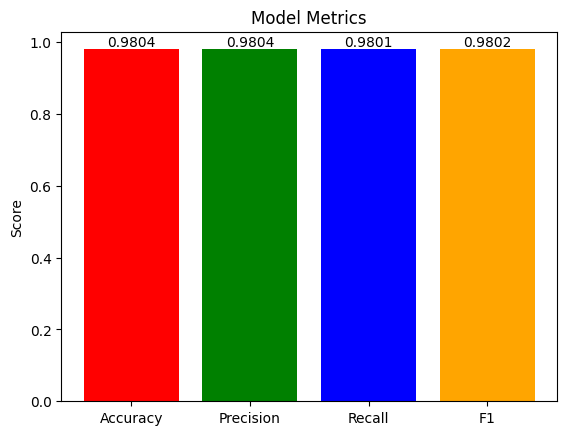

In [48]:
# Define colors for each metric
colors = ['red', 'green', 'blue', 'orange']

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the bars using the DataFrame's index and scores
bars = ax.bar(metrics_df.index, metrics_df['Scores'], color=colors)

# Add text labels on top of each bar if the height is greater than 0
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width()/2, height,
            f'{height:.4f}',  # Display metric value formatted to 4 decimal places
            ha='center', va='bottom'
        )

# Set title and labels
ax.set_title('Model Metrics')
ax.set_ylabel('Score')
plt.show()